In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
classification_report, confusion_matrix, ConfusionMatrixDisplay,
roc_auc_score, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

In [ ]:
# ============================================================
# 1) Get Data (UCI - Wine Quality / white wine)
# ============================================================
DATA_URL = "https://ddei5-0-ctp.trendmicro.com:443/wis/clicktime/v1/query?url=https%3a%2f%2farchive.ics.uci.edu%2fml%2fmachine%2dlearning%2ddatabases%2fwine%2dquality%2fwinequality%2dwhite.csv&umid=D7959580-487E-1806-A06B-80D205D001DB&auth=5073cb4dad045e86bdcced3b0d655694ddc668db-c79fc6716c6ef5fd25625f74f2fcbd53aa8f0b91"

df = pd.read_csv(DATA_URL, sep=";")
print("Shape:", df.shape)
display(df.head())

Shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
# ============================================================
# 2) Hedef değişkeni oluştur (kolay bir iş problemi kurgusu)
# quality >= 7 -> "good" (1), else 0
# ============================================================
df["good"] = (df["quality"] >= 7).astype(int)

X = df.drop(columns=["quality", "good"])
y = df["good"]

print("Target distribution (good=1):")
print(y.value_counts(normalize=True).rename("ratio"))

Target distribution (good=1):
good
0    0.783585
1    0.216415
Name: ratio, dtype: float64


In [ ]:
# ============================================================
# 3) Train/Test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.2,
random_state=42,
stratify=y
)

In [ ]:
# ============================================================
# 4) Baseline XGBoost modeli
# - scale_pos_weight: sınıf dengesizliğine küçük bir dokunuş
# ============================================================
pos = y_train.sum()
neg = len(y_train) - pos


base_model = XGBClassifier(
  objective="binary:logistic",
  eval_metric="auc",
  random_state=42,
  n_jobs=-1
)

base_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Değerlendirme
proba = base_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("\n=== BASELINE RESULTS ===")
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))


=== BASELINE RESULTS ===
ROC-AUC: 0.916279726808176
              precision    recall  f1-score   support

           0      0.912     0.947     0.929       768
           1      0.776     0.670     0.719       212

    accuracy                          0.887       980
   macro avg      0.844     0.808     0.824       980
weighted avg      0.883     0.887     0.884       980



Model shows strong overall performance (high ROC-AUC and accuracy). However, due to the class imbalance, its performance on identifying 'good' wines (Class 1) is notably weaker, particularly in terms of recall.
This means the model is missing about one-third of the truly 'good' wines.

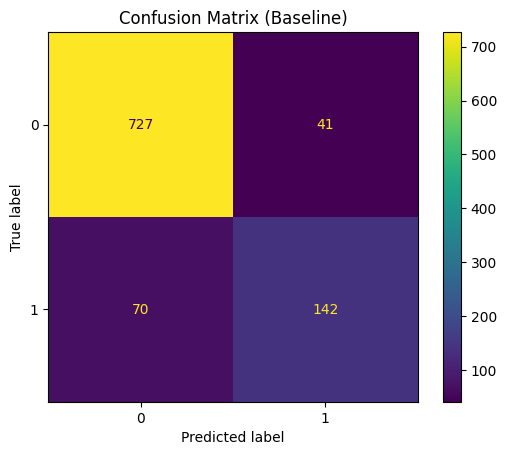

In [ ]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Baseline)")
plt.show()

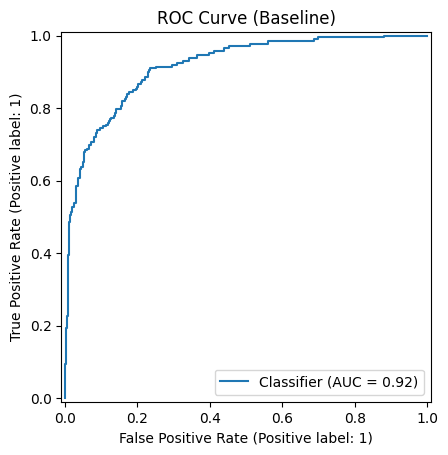

In [ ]:
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve (Baseline)")
plt.show()

In [ ]:
# ============================================================
# 5) XGBoost model
# - scale_pos_weight: sınıf dengesizliğine küçük bir dokunuş
# ============================================================
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

base_model = XGBClassifier(
  objective="binary:logistic",
  eval_metric="auc",
  random_state=42,
  n_jobs=-1,
  scale_pos_weight=scale_pos_weight
)

base_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Değerlendirme
proba = base_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("\n=== BASELINE RESULTS ===")
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))


=== BASELINE RESULTS ===
ROC-AUC: 0.9129692413522013
              precision    recall  f1-score   support

           0      0.929     0.914     0.921       768
           1      0.705     0.745     0.725       212

    accuracy                          0.878       980
   macro avg      0.817     0.830     0.823       980
weighted avg      0.880     0.878     0.879       980



İyi şarabı kaçırmak mı daha kötü yoksa kötü şaraba iyi demek mi?
Kaçırmak pahalıysa --> scale pos weight kullan
Yanlış alarm pahalıysa --> kullanma

In [ ]:
## scale_pos_weight öğrenmne aşamasında, Threshold ise karar aşamasında önemlidir
for t in [0.3, 0.5, 0.7]:
  pred_t = (proba >= t).astype(int)
  print(f"\nThreshold = {t}")
  print(classification_report(y_test, pred_t, digits=3))


Threshold = 0.3
              precision    recall  f1-score   support

           0      0.950     0.859     0.902       768
           1      0.621     0.835     0.712       212

    accuracy                          0.854       980
   macro avg      0.785     0.847     0.807       980
weighted avg      0.879     0.854     0.861       980


Threshold = 0.5
              precision    recall  f1-score   support

           0      0.929     0.914     0.921       768
           1      0.705     0.745     0.725       212

    accuracy                          0.878       980
   macro avg      0.817     0.830     0.823       980
weighted avg      0.880     0.878     0.879       980


Threshold = 0.7
              precision    recall  f1-score   support

           0      0.913     0.956     0.934       768
           1      0.807     0.670     0.732       212

    accuracy                          0.894       980
   macro avg      0.860     0.813     0.833       980
weighted avg      0.890

In [ ]:
# ============================================================
# 5) GridSearchCV ile hiperparametre arama
# Not: Eğitimde süreyi yönetmek için grid'i küçük tutuyoruz.
# ============================================================
param_grid = {
  "n_estimators": [200, 400],
  "max_depth": [3, 5],
  "learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(
estimator=XGBClassifier(
  objective="binary:logistic",
  eval_metric="auc",
  random_state=42,
  n_jobs=-1,
  scale_pos_weight=scale_pos_weight
),
param_grid=param_grid,
  scoring="roc_auc",
  cv=3,
  n_jobs=-1,
  verbose=1
)

grid.fit(X_train, y_train)

print("\n=== GRID SEARCH DONE ===")
print("Best ROC-AUC (CV):", grid.best_score_)
print("Best params:", grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

=== GRID SEARCH DONE ===
Best ROC-AUC (CV): 0.8776247653238686
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}


In [ ]:
best_model = grid.best_estimator_

# Test performansı
best_proba = best_model.predict_proba(X_test)[:, 1]
best_pred = (best_proba >= 0.5).astype(int)

print("\n=== BEST MODEL RESULTS (TEST) ===")
print("ROC-AUC:", roc_auc_score(y_test, best_proba))
print(classification_report(y_test, best_pred, digits=3))


=== BEST MODEL RESULTS (TEST) ===
ROC-AUC: 0.9144248722484276
              precision    recall  f1-score   support

           0      0.925     0.904     0.914       768
           1      0.678     0.736     0.706       212

    accuracy                          0.867       980
   macro avg      0.802     0.820     0.810       980
weighted avg      0.872     0.867     0.869       980



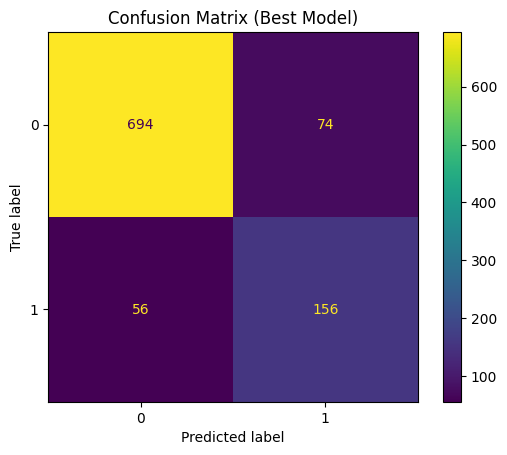

In [ ]:
cm2 = confusion_matrix(y_test, best_pred)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot(values_format="d")
plt.title("Confusion Matrix (Best Model)")
plt.show()

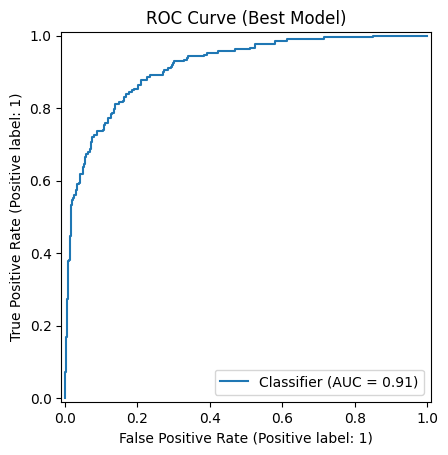

In [ ]:
RocCurveDisplay.from_predictions(y_test, best_proba)
plt.title("ROC Curve (Best Model)")
plt.show()

In [ ]:
# ============================================================
# 6) Feature Importance (1) - Model tabanlı (gain yerine default importance)
# XGBoost'ta feature_importances_ genelde "weight" benzeri bir ölçüm verir.
# ============================================================
feat_names = X.columns.tolist()
importances = best_model.feature_importances_

imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})\
.sort_values("importance", ascending=False)

print("\nTop 10 model-based importance:")
display(imp_df.head(10))


Top 10 model-based importance:


,feature,importance
10,alcohol,0.254856
1,volatile acidity,0.106034
4,chlorides,0.077974
3,residual sugar,0.076585
0,fixed acidity,0.075213
8,pH,0.074064
2,citric acid,0.072786
5,free sulfur dioxide,0.069089
6,total sulfur dioxide,0.065396
7,density,0.064808


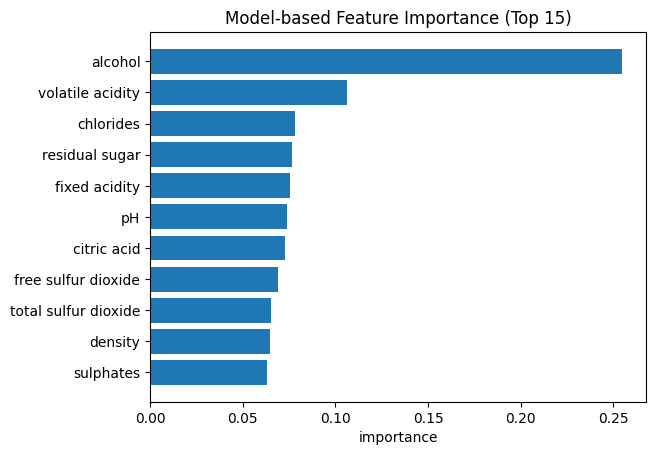

In [ ]:
plt.figure()
plt.barh(imp_df["feature"].head(15)[::-1], imp_df["importance"].head(15)[::-1])
plt.title("Model-based Feature Importance (Top 15)")
plt.xlabel("importance")
plt.show()